# Coded Diffraction Pattern (CDP) with gPIE

This notebook demonstrates phase retrieval from coded diffraction patterns using EP-based inference with the gPIE framework.

We reconstruct a complex-valued image from multiple amplitude-only Fourier measurements modulated by random phase masks.

### 1. Imports and Setup

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from gpie import model, GaussianPrior, fft2, AmplitudeMeasurement, pmse, replicate
from gpie.core.linalg_utils import random_phase_mask

# load sample image from sk-image library
import os
import sys
EXAMPLES_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, EXAMPLES_DIR)
from io_utils import load_sample_image

### 2. Problem Definition

In coded diffraction pattern (CDP) imaging, the object wave $ \mathbf{x} $ is unknown, and we observe multiple measurements of the form:

$$
\mathbf{y}_i = \left| \mathcal{F}(\mathbf{m}_i \odot \mathbf{x}) \right| + \varepsilon_i, \quad i = 1, \dots, N
$$

Where:

- $ \mathbf{m}_i $: Random phase mask
- $ \mathcal{F} $: 2D Fourier transform
- $ \varepsilon_i \sim \mathcal{N}(0, \sigma^2) $: Gaussian noise

Our goal is to recover $ \mathbf{x} $ from $\{ \mathbf{y}_i \}_{i=1}^N$.  
We apply the Bayes' theorem:

$$
p(\mathbf{x} \mid \{ \mathbf{y}_i \}) \propto \left( \prod_{i=1}^N p(\mathbf{y}_i \mid \mathbf{x}) \right) \cdot \mathcal{N}(\mathbf{x}; 0, I)
$$

We use a Gaussian prior and perform inference using Expectation Propagation (EP), in the case $N = 4$.

### 3. Define Factor Graph Class

In [12]:
@model
def coded_diffraction_pattern(shape, n_measurements, phase_masks, noise):
    x = ~GaussianPrior(event_shape=shape, label="object", dtype=np.complex64)
    x_batch = replicate(x, batch_size=n_measurements)
    y = fft2(phase_masks * x_batch)
    AmplitudeMeasurement(var=noise) << y

### 4. Prepare Data and Build Graph

In [13]:
# Settings
H = W = 256
noise_var = 1e-4
n_measurements = 4

# Phase masks
rng = np.random.default_rng(seed=9)
phase_masks = [random_phase_mask((H, W), rng=rng, dtype=np.complex64) for _ in range(n_measurements)]

# Load amplitude and phase images
amp = load_sample_image("camera", shape=(H, W))
phase = load_sample_image("moon", shape=(H, W))
true_obj = (amp * np.exp(1j * 2 * np.pi * phase)).astype(np.complex64)

# Construct graph and inject sample
g = coded_diffraction_pattern(noise=noise_var,
                              n_measurements=n_measurements,
                              phase_masks=phase_masks,
                              shape=(H, W))

# Generate synthetic data
g.set_sample("object", true_obj)
g.generate_observations(rng=np.random.default_rng(seed=999)) #rng is for synthetic noise

- A single complex-valued latent variable $ \mathbf{x} $ is defined via a Gaussian prior
- For each measurement $ i $, a random phase mask $ \mathbf{m}_i $ is applied
- The masked image is transformed via FFT and observed through amplitude-only measurement
 
- `set_sample(...)` injects the true complex image  
- `generate_observations(...)` simulates noisy observed data


### 6. Run Inference

In [14]:
n_iter = 400
pse_list = []

#inspection
def monitor(graph, t):
    if t % 50 == 0 or t == n_iter - 1:
        est = graph["object"]["mean"]
        gt = graph["object"]["sample"]
        err = pmse(est, gt)
        pse_list.append(err)
        print(f"[t={t:4d}] PMSE = {err:.5e}")

#Inference Session
device = "cuda" # or "cpu"
g.set_init_rng(np.random.default_rng(seed=1)) #RNG for random intialization of messages
g.run(n_iter=n_iter, callback=monitor, schedule = "parallel", device = device)

[t=   0] PMSE = 4.04664e-01
[t=  50] PMSE = 5.46410e-01
[t= 100] PMSE = 3.70879e-01
[t= 150] PMSE = 1.09108e-01
[t= 200] PMSE = 8.62252e-03
[t= 250] PMSE = 6.77081e-04
[t= 300] PMSE = 1.88513e-04
[t= 350] PMSE = 1.53487e-04
[t= 399] PMSE = 1.50653e-04


### 7. Visualize Results

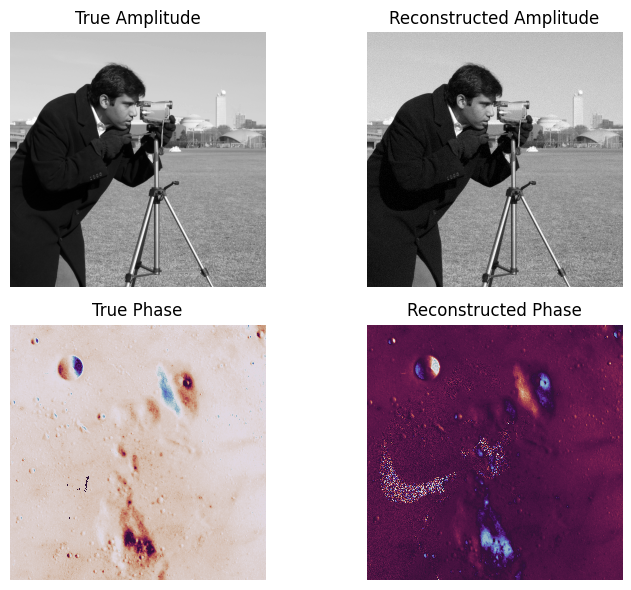

In [15]:
est = g["object"]["mean"][0] # g["object"]["mean"].shape = (1, 256, 256)

true_amp = np.abs(true_obj)
true_phase = np.angle(true_obj) * (true_amp > 1e-5)

est_amp = np.abs(est)
est_phase = np.angle(est) * (true_amp > 1e-5)

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes[0,0].imshow(true_amp, cmap='gray')
axes[0,0].set_title("True Amplitude")

axes[0,1].imshow(est_amp, cmap='gray')
axes[0,1].set_title("Reconstructed Amplitude")

axes[1,0].imshow(true_phase, cmap='twilight')
axes[1,0].set_title("True Phase")

axes[1,1].imshow(est_phase, cmap='twilight')
axes[1,1].set_title("Reconstructed Phase")

for ax in axes.flat:
    ax.axis("off")

plt.tight_layout()
plt.show()
